## Hybrid method: Recursive feature addition

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Build a machine learning model with only 1 feature, the most important one, and calculate the model metric for performance.

3) Add one feature -the most important- and build a machine learning algorithm utilising the added and any feature from previous rounds.

4) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

5) If the metric increases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

6) Repeat steps 2-5 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it adds as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step forward feature selection we learned in previous lectures lies in that it does not add all possible features first, in order to determine which one to keep. It adds the most important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be kept or not. And then it moves to the next feature.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the increase in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the increase the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score, r2_score

In [2]:
# load dataset
data = pd.read_csv('paribas.csv', nrows=50000)
data.shape

(50000, 133)

In [3]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [4]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [5]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [6]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.713140


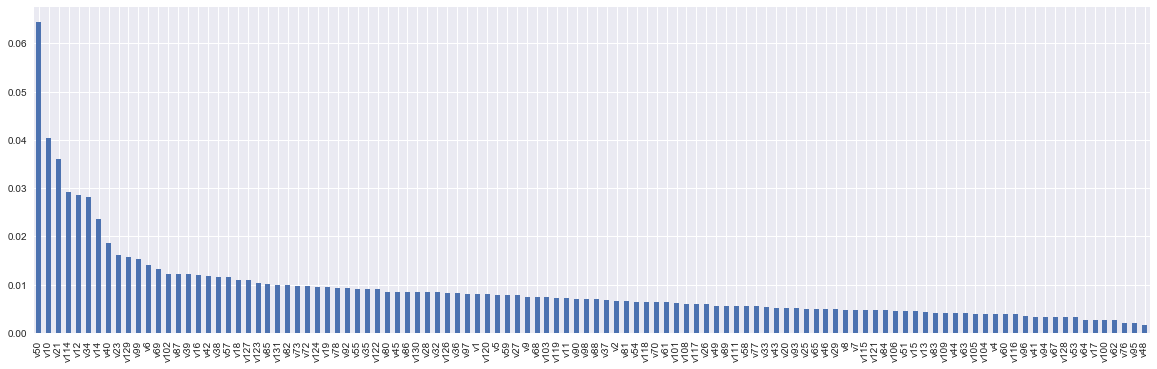

In [7]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [8]:
# view the list of ordered features
features = list(features.index)
features

['v50',
 'v10',
 'v21',
 'v114',
 'v12',
 'v34',
 'v14',
 'v40',
 'v23',
 'v129',
 'v99',
 'v6',
 'v69',
 'v102',
 'v87',
 'v39',
 'v16',
 'v42',
 'v38',
 'v57',
 'v18',
 'v127',
 'v123',
 'v85',
 'v131',
 'v82',
 'v73',
 'v72',
 'v124',
 'v19',
 'v78',
 'v92',
 'v55',
 'v35',
 'v122',
 'v80',
 'v45',
 'v86',
 'v130',
 'v28',
 'v32',
 'v126',
 'v36',
 'v97',
 'v1',
 'v120',
 'v5',
 'v59',
 'v27',
 'v9',
 'v68',
 'v103',
 'v119',
 'v11',
 'v90',
 'v98',
 'v88',
 'v37',
 'v2',
 'v81',
 'v54',
 'v118',
 'v70',
 'v61',
 'v101',
 'v108',
 'v117',
 'v26',
 'v49',
 'v89',
 'v111',
 'v58',
 'v77',
 'v33',
 'v43',
 'v20',
 'v93',
 'v25',
 'v65',
 'v46',
 'v29',
 'v8',
 'v7',
 'v115',
 'v121',
 'v84',
 'v106',
 'v51',
 'v15',
 'v13',
 'v83',
 'v109',
 'v44',
 'v63',
 'v105',
 'v104',
 'v4',
 'v60',
 'v116',
 'v96',
 'v41',
 'v94',
 'v67',
 'v128',
 'v53',
 'v64',
 'v17',
 'v100',
 'v62',
 'v76',
 'v95',
 'v48']

In [9]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
auc_score_first = roc_auc_score(y_test, y_pred_test)
print('Test one feature xgb ROC AUC=%f' % (auc_score_first))

Test one feature xgb ROC AUC=0.681754


In [10]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with one feature
    print('All features Test ROC AUC={}'.format((auc_score_first)))

    # determine the increase in the roc-auc
    diff_auc = auc_score_int - auc_score_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  v10  which is feature  1  out of  112
New Test ROC AUC=0.7007286667701044
All features Test ROC AUC=0.681754474366548
Increase in ROC AUC=0.018974192403556356
keep:  v10

testing feature:  v21  which is feature  2  out of  112
New Test ROC AUC=0.698898868421512
All features Test ROC AUC=0.7007286667701044
Increase in ROC AUC=-0.0018297983485923153
remove:  v21

testing feature:  v114  which is feature  3  out of  112
New Test ROC AUC=0.7066980932102036
All features Test ROC AUC=0.7007286667701044
Increase in ROC AUC=0.005969426440099235
keep:  v114

testing feature:  v12  which is feature  4  out of  112
New Test ROC AUC=0.7073187692534103
All features Test ROC AUC=0.7066980932102036
Increase in ROC AUC=0.0006206760432067027
remove:  v12

testing feature:  v34  which is feature  5  out of  112
New Test ROC AUC=0.7070767006646881
All features Test ROC AUC=0.7066980932102036
Increase in ROC AUC=0.00037860745448448085
remove:  v34

testi

New Test ROC AUC=0.7140841504540429
All features Test ROC AUC=0.7163906018648984
Increase in ROC AUC=-0.0023064514108555034
remove:  v97

testing feature:  v1  which is feature  44  out of  112
New Test ROC AUC=0.7158929020405027
All features Test ROC AUC=0.7163906018648984
Increase in ROC AUC=-0.0004976998243957365
remove:  v1

testing feature:  v120  which is feature  45  out of  112
New Test ROC AUC=0.7154213164763277
All features Test ROC AUC=0.7163906018648984
Increase in ROC AUC=-0.0009692853885707731
remove:  v120

testing feature:  v5  which is feature  46  out of  112
New Test ROC AUC=0.7156575531268609
All features Test ROC AUC=0.7163906018648984
Increase in ROC AUC=-0.0007330487380375894
remove:  v5

testing feature:  v59  which is feature  47  out of  112
New Test ROC AUC=0.7159067112810349
All features Test ROC AUC=0.7163906018648984
Increase in ROC AUC=-0.00048389058386355543
remove:  v59

testing feature:  v27  which is feature  48  out of  112
New Test ROC AUC=0.7145256

New Test ROC AUC=0.7157865092400094
All features Test ROC AUC=0.7174189587457817
Increase in ROC AUC=-0.0016324495057722377
remove:  v106

testing feature:  v51  which is feature  87  out of  112
New Test ROC AUC=0.7168127824051337
All features Test ROC AUC=0.7174189587457817
Increase in ROC AUC=-0.0006061763406479681
remove:  v51

testing feature:  v15  which is feature  88  out of  112
New Test ROC AUC=0.7160561839801172
All features Test ROC AUC=0.7174189587457817
Increase in ROC AUC=-0.0013627747656644873
remove:  v15

testing feature:  v13  which is feature  89  out of  112
New Test ROC AUC=0.7169035535022749
All features Test ROC AUC=0.7174189587457817
Increase in ROC AUC=-0.0005154052435067946
remove:  v13

testing feature:  v83  which is feature  90  out of  112
New Test ROC AUC=0.7159513817082208
All features Test ROC AUC=0.7174189587457817
Increase in ROC AUC=-0.001467577037560841
remove:  v83

testing feature:  v109  which is feature  91  out of  112
New Test ROC AUC=0.71775

In [12]:
# capture the 8 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))

Test selected features ROC AUC=0.717419


Using a threshold / tolerance of 0.001 we selected 8 features. The model built with 8 features is far more predictive than the one built with 1 feature. In addition, the model built with 8 features is more predictive than the one built with all the features (0.717 vs 0.713). 
And if you remember from the previous lecture where we selected 56 features by recursive feature elimination, the roc-auc was 0.715, which indicates that many of those features are still redundant, as a model built with 8 features seems to perform better.

Here we got a good uplift with just one try. However, in practice you may need to run a few runs of these method and find the right threshold, depending on how many features you are willing to include in your model and how accurate you would like it to be.

Why don't you give it a go?

### Regression

In [13]:
# load dataset
data = pd.read_csv('houseprice.csv', nrows=50000)
data.shape

(1460, 81)

In [14]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [15]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [20]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(y_test, y_pred_test)
print('Test all features xgb R2 = %f' % (r2_score_all))

Test all features xgb R2 = 0.818551


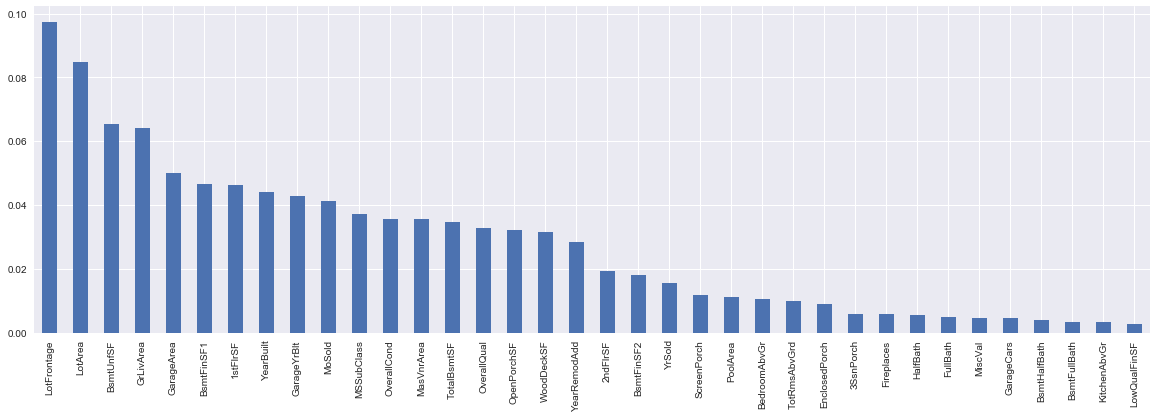

In [21]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the most to the least
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [22]:
# view the list of ordered features
features = list(features.index)
features

['LotFrontage',
 'LotArea',
 'BsmtUnfSF',
 'GrLivArea',
 'GarageArea',
 'BsmtFinSF1',
 '1stFlrSF',
 'YearBuilt',
 'GarageYrBlt',
 'MoSold',
 'MSSubClass',
 'OverallCond',
 'MasVnrArea',
 'TotalBsmtSF',
 'OverallQual',
 'OpenPorchSF',
 'WoodDeckSF',
 'YearRemodAdd',
 '2ndFlrSF',
 'BsmtFinSF2',
 'YrSold',
 'ScreenPorch',
 'PoolArea',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'EnclosedPorch',
 '3SsnPorch',
 'Fireplaces',
 'HalfBath',
 'FullBath',
 'MiscVal',
 'GarageCars',
 'BsmtHalfBath',
 'BsmtFullBath',
 'KitchenAbvGr',
 'LowQualFinSF']

In [28]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_one_feature = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict(X_test[features[0]].to_frame())
r2_score_first = r2_score(y_test, y_pred_test)
print('Test one feature xgb R2=%f' % (r2_score_first))

Test one feature xgb R2=0.014262


In [25]:
# the final step consists in adding one at a time
# all the features, from the most to the least
# important, and build an xgboost at each round.

# once we build the model, we calculate the new r2
# if the new r2 is bigger than the original one
# (with one feature), then that feature that was added
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature addition:

# first we arbitrarily set the increase in r2
# if the increase is above this threshold,
# the feature will be kept
tol = 0.001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBRegressor(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test[features_to_keep + [feature] ])

    # calculate the new r2
    r2_score_int = r2_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((r2_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((r2_score_first)))

    # determine the drop in the roc-auc
    diff_r2 = r2_score_int - r2_score_first

    # compare the increase in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Increase in r2 = {}'.format(diff_r2))
        print('keep: ', feature)
        print
        # if the increase in the r2 is bigger than the threshold
        # we keep the feature and re-adjust the r2 to the new value
        # considering the added feature
        auc_score_first = auc_score_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print


# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  LotArea  which is feature  1  out of  36
New Test ROC AUC=0.2897947569046587
All features Test ROC AUC=0.014261793423396951
Increase in r2 = 0.2755329634812618
keep:  LotArea

testing feature:  BsmtUnfSF  which is feature  2  out of  36
New Test ROC AUC=0.21834853148172295
All features Test ROC AUC=0.014261793423396951
Increase in r2 = 0.204086738058326
keep:  BsmtUnfSF

testing feature:  GrLivArea  which is feature  3  out of  36
New Test ROC AUC=0.5558584058047259
All features Test ROC AUC=0.014261793423396951
Increase in r2 = 0.541596612381329
keep:  GrLivArea

testing feature:  GarageArea  which is feature  4  out of  36
New Test ROC AUC=0.6567181184109653
All features Test ROC AUC=0.014261793423396951
Increase in r2 = 0.6424563249875683
keep:  GarageArea

testing feature:  BsmtFinSF1  which is feature  5  out of  36
New Test ROC AUC=0.7553919521136998
All features Test ROC AUC=0.014261793423396951
Increase in r2 = 0.7411301586903

In [27]:
# capture the 36 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict(X_test[features_to_keep])

# calculate roc-auc
r2_score_final = r2_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (r2_score_final))

Test selected features ROC AUC=0.822404


In this case, the model built with 36 features (r2: 0.822) performs better than the model built with one feature (r2: 0.014) and the model built with all the features (r2: 0.818).

However, from the previous lecture we know that a model built with 23 features shows a performance of 0.88. Then, if we increase the threshold here, we should be able to reduce the number of features a bit further and potentially increase the performance of our model.

Why don't you go ahead and try different thresholds?

That is all for this lecture, I hope you enjoyed it and see you in the next one!